# IMPORT,LOAD AND DEF

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from os.path import splitext,basename
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
import glob
import time
from google.colab.patches import cv2_imshow

In [3]:
os.chdir("/content/drive/MyDrive/PlateRecognition_with_DP")
from local_utils import detect_lp

In [4]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [5]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

In [6]:
def get_plate(image_path, Dmax=608, Dmin=300):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

In [7]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

### Load wpod_net

In [8]:
#load wpod_net model
def loadWpodNet():
  wpod_net_path = "/content/drive/MyDrive/PlateRecognition_with_DP/wpod-net.json"
  wpod_net = load_model(wpod_net_path)
  return wpod_net

In [9]:
wpod_net = loadWpodNet()

Loading model successfully...



### Load character MobileNets model and predict function

In [10]:
# Load model architecture, weight and labels
def loadCharacterModel(): 
 json_file = open('MobileNets_character_recognition.json', 'r')
 loaded_model_json = json_file.read()
 json_file.close()
 model = model_from_json(loaded_model_json)
 model.load_weights("License_character_recognition_weight.h5")
 print("[INFO] Model loaded successfully...")
 return model;

In [11]:
character_model=loadCharacterModel()

[INFO] Model loaded successfully...


In [12]:
 labels = LabelEncoder()
 labels.classes_ = np.load('license_character_classes.npy')
 print("[INFO] Labels loaded successfully...")

[INFO] Labels loaded successfully...


In [13]:
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

#TESTING WITH IMAGE

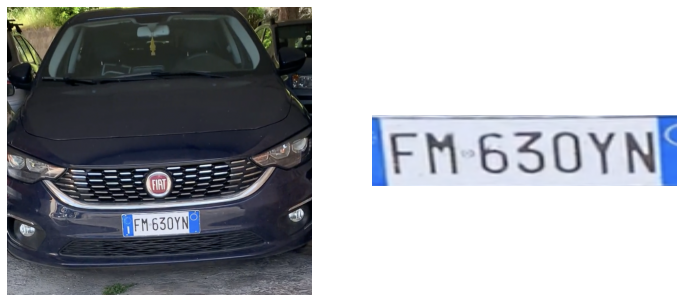

In [15]:
test_image_path = "/content/drive/MyDrive/PlateRecognition_with_DP/italian_cars/car3.png"
vehicle,LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

In [ ]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")


In [ ]:
type(binary)
cv2_imshow(binary)

In [ ]:
cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2) 

            # Sperate number and give prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)
            print( crop_characters)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)

In [ ]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")

In [ ]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,character_model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)

# FINAL FUNCTION FOR IMAGE

In [ ]:
def processing_image(image):
  final_string = ''
  crop_characters = []
  digit_w, digit_h = 30, 60
  vehicle,LpImg,cor = get_plate(test_image_path)
  plt.imshow(LpImg[0])
  if (len(LpImg)): 
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0) 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    test_roi = plate_image.copy()
    for c in sort_contours(cont):
     (x, y, w, h) = cv2.boundingRect(c)
     ratio = h/w
     if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and give prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)
    print("Detect {} letters...".format(len(crop_characters)))
    for i,character in enumerate(crop_characters):
     title = np.array2string(predict_from_model(character,character_model,labels))
     plt.title('{}'.format(title.strip("'[]"),fontsize=20))
     final_string+=title.strip("'[]")

    print(final_string)

In [ ]:
image = '"/content/drive/MyDrive/PlateRecognition_with_DP/italian_cars/car3.png'
processing_image(image)

# TEST WITH INPUT VIDEO

In [ ]:
!rm -r frames

In [ ]:
!mkdir frames

In [16]:
 #test with an input video 
def extract_frames(videofile):
    frame_count= 0
    frames = []
    cap = cv2.VideoCapture(videofile)
    assert cap.isOpened(), 'Cannot capture source'
    start = time.time()    
    while True:
        ret, frame = cap.read()
        if ret:
            frame_count += 1
            if frame_count%5==0:
              frames.append(frame)
              print("Frame  founded. FPS of the video is {:5.2f}".format( frame_count / (time.time() - start)))
        else:
          break
    return frames

In [17]:
def extract_plate_from_frames():
   plate_detected = []
   for filename in glob.glob('/content/drive/MyDrive/PlateRecognition_with_DP/frames/*.jpg'):
     try:
        print(filename)
        _,LpImg,_ = get_plate(filename)
        plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
       # convert to grayscale and blur the image
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(7,7),0)
      # Applied inversed thresh_binary 
        binary = cv2.threshold(blur, 180, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        print("Plate detected")
        plate_detected.append(binary)
     except AssertionError:
       print("Plate not found")
   return plate_detected


In [18]:
def extract_char_from_frame(Plate_detected):
   total_char = []
   digit_w, digit_h = 30, 60
   for i in range(len(Plate_detected)):
     cont = cv2.findContours(Plate_detected[i],cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
     print("Counturs detected")
     crop_characters = []
     for c in sort_contours(cont):
      (x, y, w, h) = cv2.boundingRect(c)
      ratio = h/w
      if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/Plate_detected[i].shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
           # Sperate number and gibe prediction
            kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
            thre_mor = cv2.morphologyEx(Plate_detected[i],cv2.MORPH_DILATE, kernel3)
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)
     print("Detect {} letters...".format(len(crop_characters)))
     if (len(crop_characters)==7):
      total_char.append(crop_characters)
   return  total_char

In [19]:
def final_prediction(char_array):
 final_string_array = []
 for i in range(len(char_array)):
    final_string = ''
    prediction = char_array[i]
    for j in range(len(prediction)):
      title = np.array2string(predict_from_model(prediction[j],character_model,labels))
      #plt.title('{}'.format(title.strip("'[]"),fontsize=20))
      final_string+=title.strip("'[]")
    final_string_array.append(final_string)
 final_string_array= list(dict.fromkeys(final_string_array))
 for plate in final_string_array:
    print(plate)

# Final Function for Video

In [20]:
def Processing_video(video):
   videofile= video
   frames=extract_frames(videofile)
   path = "/content/drive/MyDrive/PlateRecognition_with_DP/frames"
   for i,frame in enumerate(frames):
      cv2.imwrite(os.path.join(path, 'frames{0}.jpg'.format(i)), frame)
   Plate_detected = extract_plate_from_frames()
   char_array=extract_char_from_frame(Plate_detected)   
   final_prediction(char_array)

In [21]:
!rm -r frames

In [22]:
!mkdir frames

In [23]:
Processing_video("/content/drive/MyDrive/PlateRecognition_with_DP/video_test/videoTest/Vicino-Sera/IMG_6472.MOV")

Frame  founded. FPS of the video is  1.91
Frame  founded. FPS of the video is  3.06
Frame  founded. FPS of the video is  3.75
Frame  founded. FPS of the video is  4.22
Frame  founded. FPS of the video is  4.61
Frame  founded. FPS of the video is  4.87
Frame  founded. FPS of the video is  5.09
Frame  founded. FPS of the video is  5.26
Frame  founded. FPS of the video is  5.40
Frame  founded. FPS of the video is  5.55
Frame  founded. FPS of the video is  5.67
Frame  founded. FPS of the video is  5.79
Frame  founded. FPS of the video is  5.85
Frame  founded. FPS of the video is  5.96
Frame  founded. FPS of the video is  6.00
Frame  founded. FPS of the video is  6.08
Frame  founded. FPS of the video is  6.11
Frame  founded. FPS of the video is  6.17
Frame  founded. FPS of the video is  6.17
Frame  founded. FPS of the video is  6.24
Frame  founded. FPS of the video is  6.25
Frame  founded. FPS of the video is  6.31
Frame  founded. FPS of the video is  6.30
Frame  founded. FPS of the video i